# Where to move in? 
### (Toronto vs NYC neighborhoods)

![alt text](https://images.squarespace-cdn.com/content/v1/5d3c9dfcd2e1860001acb51d/1568582007983-1EUG6EDVM54MHIEMYZEU/ke17ZwdGBToddI8pDm48kPfW58HQawIq7Ev7Hj3E5hxZw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZUJFbgE-7XRK3dMEBRBhUpwZby2dJfdmC6uznuCz-gLnlBU1V3UIa9Xyt9ajd4Zc9pT0nIw4OBGb5aJH_SxB8e0/Toronto+Vs.+NYC "Logo Title Text 1")

## 1. Discussion and Background of the Business Problem:
### Problem Statement: Make long distance moving an easier decision

In these times of globalization is very usual that people moves from one city to another, even from one country to another for professional or academical reasons. For some, this decision is pleasant and a choice, but for some others is really hard and stressful. Leaving all the familiy, friends, traditions behind makes the task much more difficult. However, we could try to make this decision a bit easier by comparing multiple cities and find similarities of their neighborhoods in order to choose the one that will make you feel more comfortable. 

Between 1993 and 2013 USA was in the TOP 5 countries of immigration to Canada and Canada in the TOP 15 countries to USA. For this reason I find it representative to center the analysis in two cities: NYC and Toronto. So if you currently live in East Toronto, which NYC neighborhood would be the most suitable for you to move in? This is the question we will answer at the end of the analysis, but first let me walk you through all the steps of the project in this long journey from NYC to Toronto or viceversa.

## 2. Description of the data used for the analysis:
In this analysis I will use multiple datasets coming from different sources
- From the **UN**   
    *'International migration flows to and from selected countries: The 2015 revision.'* We will use USA and Canada data files only.   
	The dataset contains annual data on the flows of international migrants as recorded by the countries of destination. The data presents both inflows and outflows according to the place of birth, citizenship or place of previous / next residence both for foreigners and nationals. The current version presents data available from 45 countries.  
	source: https://www.un.org/en/development/desa/population/migration/data/empirical2/migrationflows.asp#
    
	
- From **NYU** (IBM downloaded version)  
	*'2014 New York City Neighborhood Names'*  
	To get a list of the NYC neighborhoods with coordinates.  
    source:https://geo.nyu.edu/catalog/nyu_2451_34572  
    source used: https://cocl.us/new_york_dataset
	
    
- From **Wikipedia**  
	*'List of postal codes of Canada: M.'*      
	It contains full list of the neighborhoods around Toronto by Postal Code  
    source: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
	
    
- **Geocoder API**  
	To get the coordinates of Toronto neighborhoods and NYC
    
	
- **Foursquare venues API**  
	Will give us the list of venues for each neighborhood in order to make the comparison between them
    
#### STEPS TO FOLLOW
- First we will need to obtain the coordinates of NYC and Toronto neighborhoods.  
For that purpose we will use *2014 New York City Neighborhood Names*. In case of Toronto we will need an extra step cause coordinates are not available in the Wikipedia *List of postal codes of Canada: M.*. That's how we will use Geocoder to get the coordinates from the Postal Codes given in the list. After that, we will merge Toronto's and NYC coordinates list into the same dataset in order to manage alltogether.  
- With the list of centroids obtained in the previous step, we will run the Foursquare API in order to find all the venues located around those places 
- Afterwards by using the k-means algorithm we will determine the similarities on the neighborhoods

## 3. Data Preparation

First we need to install and import all the dependencies that we will use later. Make sure you uncomment the following lines in case you don't have GEOCODER and FOLIUM libraries installed.

In [98]:
#GEOCODER
#!conda install -c conda-forge/label/cf202003 geocoder
!pip -q install geocoder
print('Geocoder installed successfully')

#FOLIUM
#!conda install -c conda-forge folium=0.5.0 --yes
!pip -q install folium
print('Folium installed successfully')

Geocoder installed successfully
Folium installed successfully


In [99]:
import pandas as pd
import numpy as np
import geocoder
import folium
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from sklearn.cluster import KMeans 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from IPython.display import HTML
from IPython.display import display

In [100]:
# @hidden_cell
CLIENT_ID = 'yourFoursquareID' # your Foursquare ID
CLIENT_SECRET = 'yourFoursquareSecret' # your Foursquare Secret
VERSION = '20200501' # Foursquare API version
LIMIT = 100

read_backup = 1

# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='XXXXXXXXXXXXXXX', project_access_token='XXXXXXXXXXXXXXXXXXXX')
pc = project.project_context

In [101]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude


### 3.1. Obtain location data

#### New York City Neighborhoods

First we will download the the file from NYU (IBM downloaded version)  
__*'2014 New York City Neighborhood Names'*__

In [102]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
nyNeigh_data = newyork_data['features']    

Data downloaded!


In [103]:
#Load NY data into neighborhood DF
for data in nyNeigh_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [104]:
print('There are {} neighborhoods for NYC'.format(neighborhoods.shape[0]))

There are 306 neighborhoods for NYC


We can see that there are many neighborhoods in the NYC area, hence we will focus the analysis in Manhattan and Brooklyn boroughs. These boroughs represent almost the same area than Toronto.

In [105]:
neighborhoods = neighborhoods[(neighborhoods['Borough']=='Manhattan')|(neighborhoods['Borough']=='Brooklyn')]
print("Manhattan and Brooklyn boroughs have {} neighborhoods for analysis".format(neighborhoods.shape[0]))
neighborhoods['Country'] = 'USA'
neighborhoods.head()

Manhattan and Brooklyn boroughs have 110 neighborhoods for analysis


,Borough,Neighborhood,Latitude,Longitude,Country
6,Manhattan,Marble Hill,40.876551,-73.910660,USA
46,Brooklyn,Bay Ridge,40.625801,-74.030621,USA
47,Brooklyn,Bensonhurst,40.611009,-73.995180,USA
48,Brooklyn,Sunset Park,40.645103,-74.010316,USA
49,Brooklyn,Greenpoint,40.730201,-73.954241,USA


#### Toronto Area Neighborhoods

To obtain the Toronto neighborhoods we will use the **Wikipedia** table for Postal Codes, then merge it with the latitude/longitude of each Postal Code from **Geocoder**

In [107]:
#Reading the Wikipedia table
link = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
CanadaPC = pd.read_html(link)[0]

#CLEANING THE TABLE
# Exclude Not Assigned Borough
df_Canada = CanadaPC.loc[(CanadaPC['Borough'] != 'Not assigned')] 
# If there's no Neighbohood then it assigns the Borough
df_Canada.Neighborhood.fillna(df_Canada.Borough, inplace=True)
#Remove space from Postal code column name
df_Canada.rename({'Postal code':'Postal_code'}, axis=1, inplace=True)
#There are some Neighborhood duplicated with different Postal Codes, for those we will concatenate Neighborhood and Postal Code
g=df_Canada.groupby('Neighborhood').count()
g=g.where(g>1).dropna()
df_Canada.Neighborhood.loc[df_Canada.Neighborhood.isin(g.index)] = df_Canada.Neighborhood.loc[df_Canada.Neighborhood.isin(g.index)]+" "+df_Canada.Postal_code.loc[df_Canada.Neighborhood.isin(g.index)]

# Resets the index of the DF
df_Canada.reset_index(drop=True, inplace=True)                           
# Replaces '/' separator to ',' separtor for multiple neighborhoods
df_Canada['Neighborhood'].replace(to_replace ='/', value = ',', regex = True,inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [108]:
print('There are {} neighborhoods for Toronto'.format(df_Canada.shape[0]))
print("Let's see the first 5 rows of data")
df_Canada.head()

There are 103 neighborhoods for Toronto
Let's see the first 5 rows of data


,Postal_code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


For each postal code in previous step, we look for the coordinates using **Geocoder** and display the first 5 rows of data

In [109]:
#Loop into the Canada's df to run geocoder for each Postal Code
Can_Locations = pd.DataFrame(columns=['Postal_Code', 'Latitude', 'Longitude'])

for i in range(len(df_Canada)) :
    
    lat_lng_coords = None

    postal_code = df_Canada.loc[i, "Postal_code"]
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng

    neighborhood_lat = lat_lng_coords[0]
    neighborhood_lon = lat_lng_coords[1]
    
    Can_Locations = Can_Locations.append({'Postal_Code': postal_code,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Can_Locations['Country'] = 'Canada'
Can_Locations.head()

,Postal_Code,Latitude,Longitude,Country
0,M3A,43.752935,-79.335641,Canada
1,M4A,43.728102,-79.311890,Canada
2,M5A,43.650964,-79.353041,Canada
3,M6A,43.723265,-79.451211,Canada
4,M7A,43.661790,-79.389390,Canada


#### Merge NYC and Toronto data


As we want to analyse the cities alltogether , we append Toronto data into the neighborhoods table (that already stores NYC data)

In [110]:
neighborhoods = neighborhoods.append(df_Canada.set_index('Postal_code').join(Can_Locations.set_index('Postal_Code')))
neighborhoods = neighborhoods.reset_index(drop=True)
print("There are {} neighborhoods in total for analysis".format(neighborhoods.shape[0]))

There are 213 neighborhoods in total for analysis


#### Map of the Locations
Let's take a look at the neighborhoods chosen for the analysis

In [111]:
#First we need to obtain Toronto's coords
g = geocoder.arcgis('Toronto, ON')
lat_lng_coords = g.latlng

lat_tor= lat_lng_coords[0]
long_tor = lat_lng_coords[1]

#Now we obtain NYC's coords
g = geocoder.arcgis('New York City, NY')
lat_lng_coords = g.latlng

lat_nyc= lat_lng_coords[0]
long_nyc = lat_lng_coords[1]

#Instances of both maps
map_city_tor = folium.Map(location=[lat_tor, long_tor], zoom_start=11,min_zoom=10, width='100%')
map_city_ny = folium.Map(location=[lat_nyc, long_nyc], zoom_start=12,min_zoom=11, width='100%')

for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '({}), {}'.format(neighborhood.replace("'","&apos"), borough.replace("'","&apos"))
    label = folium.Popup(label, parse_html=True)
    
    if borough !='Manhattan' and borough !='Brooklyn':
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_city_tor)
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_city_ny)

In [112]:
#Displaying both maps side by side
from IPython.core.display import display, HTML

htmlcities = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 1px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 1px solid black"></iframe>'
           .format(map_city_tor.get_root().render().replace('"', '&quot;'),500,500,
                   map_city_ny.get_root().render().replace('"', '&quot;'),500,500))
display(htmlcities)

### 3.2. Exploring Neighborhoods
Now it is time to get the nearby venues for each location. We will focus in a radio of 500m and and a limit of 100 venues for each centroid.

In [113]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        request = requests.get(url).json()
        
        if "totalResults" in request["response"]:
            if request["response"]['totalResults'] == 0 :
                print("No venues found around neighborhood {}".format(name))        
                  
        results = request["response"]['groups'][0]['items']
            
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [114]:
if read_backup == 0:
    neigh_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                       latitudes=neighborhoods['Latitude'],
                                       longitudes=neighborhoods['Longitude']
                                  )
else:
    neigh_venues = pd.read_csv(project.get_file('venues_backup.csv'))
    
print("{} venues were found".format(neigh_venues.shape[0]))
neigh_venues.head()

7965 venues were found


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


#### Neighborhoods out of scope
Bear in mind, that if no venues were found for a neighborhood, then we will not be able to keep it in scope.

In [116]:
print("There are {} neighborhoods out of scope of analysis".format(len(neighborhoods['Neighborhood']) - len(neigh_venues['Neighborhood'].unique())))
neighborhoods[neighborhoods['Neighborhood'].isin(neigh_venues['Neighborhood'].unique())==False]

There are 4 neighborhoods out of scope of analysis


,Borough,Neighborhood,Latitude,Longitude,Country
145,East York,East Toronto,43.687046,-79.333890,Canada
160,North York,Humber Summit,43.759381,-79.557174,Canada
172,Central Toronto,Roselawn,43.710634,-79.418748,Canada
205,Scarborough,Upper Rouge,43.834768,-79.204101,Canada


In [117]:
print('There are {} uniques categories.'.format(len(neigh_venues['Venue Category'].unique())))

There are 416 uniques categories.


**As there are many categories we will try to group them using the Forquare API Categories**

In [118]:
# create the API request URL
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    VERSION)

# make the GET request
categories = requests.get(url).json()

results = categories["response"]["categories"]

# define the dataframe columns
columncat_names = ['Category','Subcategory','Sub2','Sub3','Sub4'] 

# instantiate the dataframe
df_cat = pd.DataFrame(columns=columncat_names)

In [140]:
for i in results:
    for j in i["categories"]:
        if len(j["categories"]) > 0:
            for k in j["categories"]:
                if len(k["categories"]) > 0:
                    for l in k["categories"]:
                        if len(l["categories"]) > 0:
                            for m in l["categories"]:
                                df_cat = df_cat.append({"Category" : i['name'], "Subcategory" : j['name'], "Sub2" : k['name'],"Sub3" : l['name'],"Sub4" : m['name']},ignore_index=True)
                        else:
                            df_cat = df_cat.append({"Category" : i['name'], "Subcategory" : j['name'], "Sub2" : k['name'],"Sub3" : l['name'],"Sub4" : l['name']},ignore_index=True)
                else:
                    df_cat = df_cat.append({"Category" : i['name'], "Subcategory" : j['name'], "Sub2" : k['name'],"Sub3" : k['name'],"Sub4" : k['name']},ignore_index=True)
        else:
            df_cat = df_cat.append({"Category" : i['name'], "Subcategory" : j['name'], "Sub2" : j['name'],"Sub3" : j['name'],"Sub4" : j['name']},ignore_index=True)

In [120]:
cols = neigh_venues.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, str)) else x)
neigh_venues.columns = cols

neigh_venues['Category'] = neigh_venues['Venue_Category'].map(df_cat.set_index('Sub4')['Category'])

neigh_venues.Category.fillna(neigh_venues.Venue_Category, inplace=True)

**Let's check how many subcategories we have now in the results**

In [121]:
neigh_venues.Category.nunique()

65

#### As there are many venues & categories we will transform the data into one hot encoding and group the venues by neighborhood given the mean of the frequency of occurrence of each category

In [122]:
# one hot encoding
# neigh_onehot = pd.get_dummies(neigh_venues[['Venue Category']], prefix="", prefix_sep="")
neigh_onehot = pd.get_dummies(neigh_venues[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neigh_onehot['Neighborhood'] = neigh_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [neigh_onehot.columns[-1]] + list(neigh_onehot.columns[:-1])
neigh_onehot = neigh_onehot[fixed_columns]

neigh_grouped = neigh_onehot.groupby('Neighborhood').mean().reset_index()
neigh_grouped.head(10)

,Neighborhood,African Restaurant,Airport,American Restaurant,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Bar,Beach,...,Ski Area,South American Restaurant,Spanish Restaurant,Spiritual Center,Stadium,Thai Restaurant,Theme Park,Train Station,Travel & Transport,Turkish Restaurant
0,Agincourt,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,"Alderwood , Long Branch",0.0,0.0,0.000000,0.100000,0.000000,0.100000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,Bath Beach,0.0,0.0,0.000000,0.000000,0.040816,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.020408,0.020408
3,"Bathurst Manor , Wilson Heights , Downsview North",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,Battery Park City,0.0,0.0,0.000000,0.070175,0.000000,0.017544,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.052632,0.000000
5,Bay Ridge,0.0,0.0,0.034091,0.011364,0.000000,0.000000,0.0,0.034091,0.0,...,0.0,0.0,0.011364,0.0,0.0,0.022727,0.0,0.0,0.000000,0.000000
6,Bayview Village,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
7,"Bedford Park , Lawrence Manor East",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.045455,0.0,0.0,0.000000,0.000000
8,Bedford Stuyvesant,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.074074,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
9,Bensonhurst,0.0,0.0,0.035714,0.000000,0.000000,0.000000,0.0,0.035714,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000


## 4. Modelling k-means Clusters

In [126]:
X = neigh_grouped.iloc[:,1:(neigh_grouped.shape[1]-1)].values
X = np.nan_to_num(X)

### 4.1 Model Evaluation (using Elbow method)
Elbow method gives us an idea on what a good k number of clusters would be, based on the sum of squared distance (SSE) between data points and their assigned clusters’ centroids. 

<module 'matplotlib.pyplot' from '/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

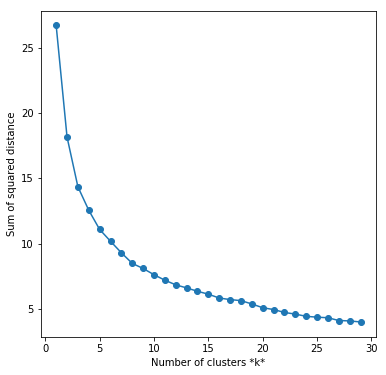

In [127]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 30))

for k in list_k:
    km = KMeans(init = "k-means++",n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt

As we can see, is a bit hard to figure out a good number of clusters to use, because the curve is monotonically decreasing and there's no obvious point where the curve starts flattening out. However it seems that the number is around 8 and 12. For that reason I'll take the 10 as the mean parameter.

### 4.2 Training the final model

In [136]:
clusterNum = 10
k_means = KMeans(init = "k-means++", n_clusters = clusterNum)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[0 6 6 4 0 6 5 1 4 4 6 2 0 3 4 3 1 6 6 0 6 6 6 5 6 3 6 6 5 1 6 6 6 3 1 3 6
 3 4 6 6 6 1 6 4 1 1 0 4 4 4 2 6 4 2 7 4 1 0 0 6 3 6 6 6 6 3 3 4 6 1 1 3 3
 2 6 6 0 6 4 0 6 9 6 6 6 6 6 4 1 2 0 3 2 4 0 8 5 1 6 8 7 6 4 4 3 3 4 6 0 6
 6 6 4 8 1 4 6 1 4 0 6 6 4 4 8 7 4 5 6 1 3 5 6 2 6 8 9 3 4 6 7 0 4 4 1 5 6
 4 4 1 6 6 1 1 0 5 7 4 1 3 4 7 6 6 6 3 6 4 3 4 6 0 0 3 4 6 1 5 7 5 0 1 0 0
 6 6 6 6 1 6 4 3 1 6 1 0 4 6 4 1 3 4 4 4 4 4 5 6]


In [137]:
neigh_grouped["Cluster"] = labels

cities_clustered = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
cities_clustered = cities_clustered.join(neigh_grouped.set_index('Neighborhood'), on='Neighborhood')

cities_clustered.dropna(axis=0, inplace=True)
print(cities_clustered.shape)
cities_clustered.head()

(209, 71)


,Borough,Neighborhood,Latitude,Longitude,Country,African Restaurant,Airport,American Restaurant,Arts & Entertainment,Asian Restaurant,...,South American Restaurant,Spanish Restaurant,Spiritual Center,Stadium,Thai Restaurant,Theme Park,Train Station,Travel & Transport,Turkish Restaurant,Cluster
0,Manhattan,Marble Hill,40.876551,-73.910660,USA,0.0,0.0,0.076923,0.038462,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,4.0
1,Brooklyn,Bay Ridge,40.625801,-74.030621,USA,0.0,0.0,0.034091,0.011364,0.0,...,0.0,0.011364,0.0,0.000000,0.022727,0.0,0.0,0.000000,0.0,6.0
2,Brooklyn,Bensonhurst,40.611009,-73.995180,USA,0.0,0.0,0.035714,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,4.0
3,Brooklyn,Sunset Park,40.645103,-74.010316,USA,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.028571,0.000000,0.0,0.0,0.000000,0.0,4.0
4,Brooklyn,Greenpoint,40.730201,-73.954241,USA,0.0,0.0,0.011111,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.011111,0.0,0.0,0.011111,0.0,6.0


## 5. Results and Discussion:
### 5.1 Visualize the results

Let's visualize the resulting clusters in a map to see if there are similarities between NYC and Toronto's neighborhoods

In [138]:
# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# create NYC map
lat_nyc = 40.741349
long_nyc= -73.992644
map_nyc = folium.Map(location=[lat_nyc, long_nyc], zoom_start=12,min_zoom=11, width='100%')


# add markers to the map
for lat, lon, poi, cluster, borough in zip(cities_clustered['Latitude'], cities_clustered['Longitude'], cities_clustered['Neighborhood'], cities_clustered['Cluster'],cities_clustered['Borough']):
    label = folium.Popup(str(poi), parse_html=True)
    
    if borough =='Manhattan' or  borough =='Brooklyn':
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(map_nyc)

# create maps
lat_tor = 43.701023
long_tor = -79.380847
map_toronto = folium.Map(location=[lat_tor, long_tor], zoom_start=11,min_zoom=10, width='100%')

# add markers to the map
for lat, lon, poi, cluster, borough in zip(cities_clustered['Latitude'], cities_clustered['Longitude'], cities_clustered['Neighborhood'], cities_clustered['Cluster'],cities_clustered['Borough']):
    label = folium.Popup(str(poi.replace("'","&apos")), parse_html=True)
    
    if borough !='Manhattan' and borough !='Brooklyn':
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(map_toronto)

from IPython.core.display import display, HTML


htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 1px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 1px solid black"></iframe>'
           .format(map_toronto.get_root().render().replace('"', '&quot;'),500,500,
                   map_nyc.get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)        

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


#### Here we can check the how the clusters were build, meaning how many neighborhoods of each country where clustered together

In [139]:
df_bar = cities_clustered.groupby(['Cluster','Country']).count().Neighborhood.to_frame()
df_bar.reset_index(inplace=True)  
df_bar

,Cluster,Country,Neighborhood
0,0.0,Canada,8
1,0.0,USA,13
2,1.0,Canada,17
3,1.0,USA,9
4,2.0,Canada,6
5,2.0,USA,1
6,3.0,Canada,10
7,3.0,USA,12
8,4.0,Canada,21
9,4.0,USA,21


### 5.2 Findings
According to this analysis we can conclude that if you are planning to move from NYC to Toronto or viceversa:
- Almost always there's a chance to find a neighborhood that resembles to your current
- If you live in Toronto's city centre you might probably want to move to Manhattan and viceversa
- If you live outside Toronto, then you should look for something in Brooklyn
- If you live in Brooklyn, depending on the neighborhood, you could find places inside Toronto or in the outskirts of the city  


## 6. Conclusion

This has been a small glimpse of how real life data-science projects look like. Using some python libraries to scrap web-data, APIs to explore these cities and saw their similar neighborhoods, using k-means algorithm to cluster and Folium leaflet maps to visualize them. The results obtained resembles a lot to what I have expected. As Toronto centre it not as large as Manhattan in terms of density, Manhattan neighborhoods were grouped in fewer clusters. For that reason it might be easier to find a Neighborhood in NYC that resembles to one in Toronto, than the other way around. However, There's a lot of potential and chance for improvements to represent even more realistic comparisons using other kind of data.